In [2]:
import pandas as pd
import numpy as np
import torch

import warnings
warnings.filterwarnings('ignore')

from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import joblib

In [3]:
df_train = pd.read_csv('./input/train.csv')
df_train

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme
0,Train_0,15,9,5,ক্ট্রো
1,Train_1,159,0,0,হ
2,Train_2,22,3,5,খ্রী
3,Train_3,53,2,2,র্টি
4,Train_4,71,9,5,থ্রো
...,...,...,...,...,...
200835,Train_200835,22,7,2,র্খে
200836,Train_200836,65,9,0,ত্তো
200837,Train_200837,2,1,4,অ্যা
200838,Train_200838,152,9,0,স্নো


In [4]:
index = 0
HEIGHT = 137
WIDTH = 236

In [5]:
# 빠른방법
img_ids = df_train['image_id'].values
img_id = img_ids[index]
img_id

'Train_0'

In [4]:
df_train['image_id'].values

array(['Train_0', 'Train_1', 'Train_2', ..., 'Train_200837',
       'Train_200838', 'Train_200839'], dtype=object)

In [6]:
img = joblib.load(f'./input/train_images/{img_id}.pkl').astype(np.uint8)

In [7]:
img = img.reshape(HEIGHT,WIDTH)

In [8]:
img = 255-img

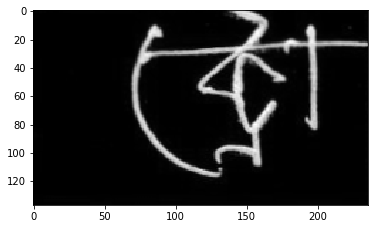

In [9]:
plt.imshow(img, cmap='gray')

In [10]:
# pytorch 에 넣어주려면 채널 추가해야함
img = img[:,:,np.newaxis]

In [11]:
img.shape

(137, 236, 1)

In [12]:
label_1 = df_train.iloc[index].grapheme_root
label_2 = df_train.iloc[index].vowel_diacritic
label_3 = df_train.iloc[index].consonant_diacritic

In [13]:
label_1,label_2,label_3

(15, 9, 5)

---

In [14]:
# torch img : (B, W, H, C) -> (B, C, W, H)  permute 쓴다
# (16,137,236,1) -> (16,1,137,236)

class BengaliDataset(Dataset):
    def __init__(self, csv, img_height, img_width):
        self.csv = csv.reset_index()
        self.img_ids = csv['image_id'].values
        self.img_height = img_height
        self.img_width = img_width
        
    def __len__(self):
        return len(self.csv)
    
    def __getitem__(self, index):
        img_id = self.img_ids[index]
        img = joblib.load(f'./input/train_images/{img_id}.pkl')
        img = img.reshape(self.img_height, self.img_width).astype(np.uint8)
        img = 255 - img
        img = img[:,:,np.newaxis]
        
        label_1 = self.csv.iloc[index].grapheme_root
        label_2 = self.csv.iloc[index].vowel_diacritic
        label_3 = self.csv.iloc[index].consonant_diacritic
        
        return (torch.tensor(img, dtype=torch.float).permute(2,0,1), torch.tensor(label_1, dtype= torch.long),
               torch.tensor(label_2, dtype= torch.long), torch.tensor(label_3, dtype= torch.long))

In [15]:
img.shape

(137, 236, 1)

In [16]:
torch.tensor(img).shape

torch.Size([137, 236, 1])

In [17]:
torch.tensor(img, dtype=torch.float).permute(2,0,1)

tensor([[[1., 2., 3.,  ..., 1., 2., 4.],
         [0., 2., 2.,  ..., 1., 2., 3.],
         [0., 0., 0.,  ..., 1., 1., 2.],
         ...,
         [1., 1., 2.,  ..., 2., 1., 3.],
         [1., 1., 1.,  ..., 2., 2., 3.],
         [1., 1., 1.,  ..., 2., 2., 4.]]])

### train, val 만들기

In [18]:
df_train['fold'] = pd.read_csv('./input/df_folds.csv')['fold']

In [19]:
df_train['fold']

0         3
1         0
2         5
3         2
4         4
         ..
200835    0
200836    4
200837    2
200838    0
200839    5
Name: fold, Length: 200840, dtype: int64

In [20]:
trn_fold = [i for i in range(6) if i not in [5]]
trn_fold

[0, 1, 2, 3, 4]

In [21]:
vld_fold = [5]

In [22]:
trn_idx = df_train.loc[df_train['fold'].isin(trn_fold)].index
vld_idx = df_train.loc[df_train['fold'].isin(vld_fold)].index

In [23]:
trn_dataset = BengaliDataset(csv = df_train.loc[trn_idx], img_height = HEIGHT, img_width=WIDTH)

In [24]:
trn_dataset[0][0].shape

torch.Size([1, 137, 236])

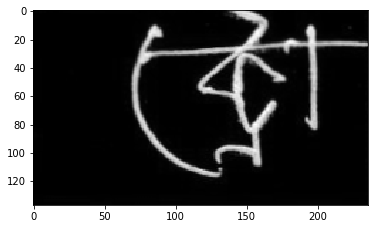

In [25]:
plt.imshow(trn_dataset[0][0].permute(1,2,0).numpy()[:,:,0], cmap = 'gray')

In [26]:
idx = np.random.randint(len(trn_idx))

In [27]:
idx = 0

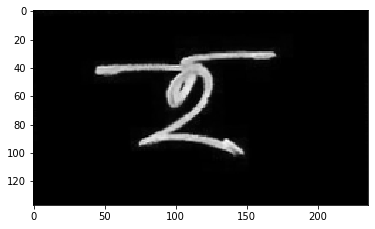

In [28]:
# 데이터셋 확인
idx += 1
plt.imshow(trn_dataset[idx][0].permute(1,2,0).numpy()[:,:,0], cmap='gray')

---

## pretrained Model

In [33]:
import pretrainedmodels

In [34]:
pretrainedmodels.model_names

['fbresnet152',
 'bninception',
 'resnext101_32x4d',
 'resnext101_64x4d',
 'inceptionv4',
 'inceptionresnetv2',
 'alexnet',
 'densenet121',
 'densenet169',
 'densenet201',
 'densenet161',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'inceptionv3',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19_bn',
 'vgg19',
 'nasnetamobile',
 'nasnetalarge',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn131',
 'dpn107',
 'xception',
 'senet154',
 'se_resnet50',
 'se_resnet101',
 'se_resnet152',
 'se_resnext50_32x4d',
 'se_resnext101_32x4d',
 'cafferesnet101',
 'pnasnet5large',
 'polynet']

In [35]:
model_name = 'resnet34'
backbone = pretrainedmodels.__dict__[model_name](pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [38]:
backbone

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# 현재 이미지는 grayscale 이라 input channel이 1이다
# 마지막 채널을 1로 바꾸거나, 학습 할 때 입력 채널을 rgb (3) 으로 바꾼다

In [39]:
# grayscale로 하는 방법
import torch.nn as nn

In [41]:
# inputchannel 1로 바꾸기
backbone.conv1 = nn.Conv2d(1,64,7,2,3, bias=False)
backbone

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
# lastLinear 바꾸기 - out_features
in_features = backbone.last_linear.in_features
in_features

512

In [45]:
backbone.last_linear = nn.Linear(in_features, 186)
backbone

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:
# 확인하기 (임의의 배치 만들기)
batches = torch.rand(6,1,137,236)
batches.shape

torch.Size([6, 1, 137, 236])

In [47]:
outputs = backbone(batches)
outputs.shape

torch.Size([6, 186])

In [48]:
outputs.min()

tensor(-2.0861, grad_fn=<MinBackward1>)

---